In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), "..")))
from example_package import model, training, datasets, metrics
from tqdm import tqdm
from scipy.stats import bootstrap
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def compute_symmetry(matrix_1, matrix_2):
    norm_factor = np.linalg.norm(matrix_1, 'fro') * np.linalg.norm(matrix_2, 'fro')
    if norm_factor == 0:
        return 0
    return np.trace(np.matmul(matrix_1.T, matrix_2)) / norm_factor

def analyze_symmetry(weight_matrix, nv, nh):
    # Define the structure of the network
    nv1 = nv//2 
    nv2 = nv//2 
    nh = 2
    
    # Extract submatrices
    V1 = weight_matrix[:nv1, :nv1]
    V2 = weight_matrix[nv1:nv1+nv2, nv1:nv1+nv2]
    V1_H = weight_matrix[:nv1, nv1+nv2:nv1+nv2+nh]
    V2_H = weight_matrix[nv1:nv1+nv2, nv1+nv2:nv1+nv2+nh]
    H_V1 = weight_matrix[nv1+nv2:nv1+nv2+nh, :nv1]
    H_V2 = weight_matrix[nv1+nv2:nv1+nv2+nh, nv1:nv1+nv2]
    
    symmetry_V1_V2 = compute_symmetry(V1, V2)
    symmetry_V1_H_V2_H = compute_symmetry(V1_H, V2_H)
    symmetry_H_V1_H_V2 = compute_symmetry(H_V1, H_V2)
    
    return symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2

def TrainBatch(model, data, epochs, sym_epochs, n_visible, n_hidden, learningRate, noise_levels, steps_statistics,
               annealing_scheme:float|torch.Tensor,n_steps=None):
        """
        annealing_scheme: temperature, or annealing scheme
        n_steps: number of steps to equilibrium, alternative to specifying a scheme 
        """
        optimizer = optim.SGD(model.parameters(), lr=learningRate)

        symmetry_V1_V2_array = []
        symmetry_V1_H_V2_H_array = []
        symmetry_H_V1_H_V2_array = []


        for iep in tqdm(range(epochs+1)):
            model.training_step(optimizer,data,noise_levels,steps_statistics,annealing_scheme,n_steps)

            if iep in sym_epochs:
                weightmatrix = model.w.detach().cpu().numpy()
                symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2 = analyze_symmetry(weightmatrix, n_visible, n_hidden)

                symmetry_V1_V2_array.append(symmetry_V1_V2)
                symmetry_V1_H_V2_H_array.append(symmetry_V1_H_V2_H)
                symmetry_H_V1_H_V2_array.append(symmetry_H_V1_H_V2)

        return symmetry_V1_V2_array, symmetry_V1_H_V2_H_array, symmetry_H_V1_H_V2_array

def create_dataset(n_visible):
    id_mat = np.identity(n_visible)
    mat = np.concatenate((id_mat, id_mat), axis=1)
    dataset = torch.tensor(mat, dtype=torch.float32)
    return dataset

In [4]:
n_visible = 4
n_hidden = 2
bias = True
dataset = create_dataset(n_visible)
epochs_to_measure = np.round(np.logspace(0, 3, 10))

#noise_levels = [0.05,0.15]
epochs = 1000
learning_rate = 2
noise_levels = [0.05,0.15] # [p_flip_to_zero,p_flip_to_one]
annealing_scheme = torch.Tensor([20,20,15,15,12,12,10,10,10,10])
steps_statistics = 10
n_steps = None
# Make an object from the model and train it
model = model.BoltzmannMachine(2*n_visible, n_hidden, None, bias)
# Train the model and capture the symmetry values
symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2 = TrainBatch(
    model, dataset, epochs, epochs_to_measure, 2*n_visible, n_hidden, learning_rate, noise_levels, steps_statistics, annealing_scheme=annealing_scheme, n_steps=n_steps)

100%|██████████| 1001/1001 [05:14<00:00,  3.18it/s]


In [ ]:
# Do statistics

In [ ]:
### Plot The resultnwithout the confidence intervalls ###

import matplotlib.pyplot as plt
import numpy as np

# Create a single figure with two subplots, adjusting figure size
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))  # Two subplots, increased size
fig.suptitle("Similarity analysis over Epochs with 2 hidden units", fontsize=18, fontweight='bold')

# Define larger font sizes for better readability
label_fontsize = 16
title_fontsize = 16
tick_fontsize = 12
legend_fontsize = 12

epochs_array = np.arange(epochs) + 1e-6  # Add small constant to avoid log(0)

# First plot
axes[0].plot(epochs_array, symmetry_V1_V2, color='blue', linewidth=2)
axes[0].set_title("Similarity between recurrent connections", fontsize=title_fontsize)
axes[0].set_xscale('symlog')

# Second plot (Now the bottom plot - This gets the x-axis label and ticks)
axes[1].plot(epochs_array, symmetry_V1_H_V2_H, color='green', linewidth=2)
axes[1].set_ylabel("Cosine similarity", fontsize=label_fontsize)
axes[1].set_title("Similarity between encodings", fontsize=title_fontsize)
axes[1].set_xscale('symlog')
axes[1].set_xlabel("Epochs", fontsize=label_fontsize)  # Add x-axis label to the second plot

# Set fixed x-axis ticks at 1, 10, and 100
fixed_ticks = [1, 10, 100]
axes[1].set_xticks(fixed_ticks)
axes[1].set_xticklabels([str(tick) for tick in fixed_ticks])  # Ensure labels are strings

# Remove grid and increase tick font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(False)

# Adjust layout to fit title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("similarity_analysis_new.png", bbox_inches="tight")
plt.show()

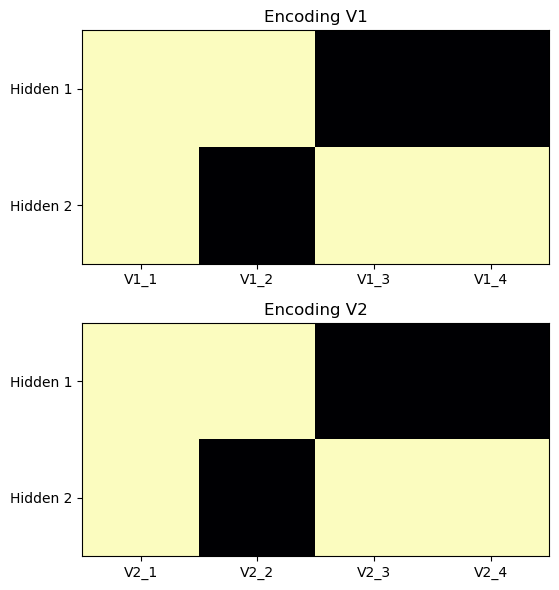

In [6]:
# Function that plots encodings
def plot_encodings(n_visible, n_hidden, bias=False):
    # Assuming y is obtained from some model
    y = model.w.detach().numpy()
    y_discrete = np.sign(y)
    final_index = -1 if bias else len(y_discrete)
    
    # Exclude the last row
    encoding_v1 = y_discrete[2*n_visible:final_index-1, :n_visible]  # Exclude last row
    encoding_v2 = y_discrete[2*n_visible:final_index-1, n_visible:2*n_visible]  # Exclude last row

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))

    # Plot Encoding V1
    im1 = axes[0].imshow(encoding_v1, cmap='magma', vmin=-1, vmax=1)
    axes[0].set_title('Encoding V1')
    axes[0].set_xticks(np.arange(n_visible))
    axes[0].set_xticklabels([f'V1_{i+1}' for i in range(n_visible)])
    axes[0].set_yticks(np.arange(encoding_v1.shape[0]))  # Adjust y-ticks for remaining rows
    axes[0].set_yticklabels([f'Hidden {i+1}' for i in range(encoding_v1.shape[0])])

    # Plot Encoding V2
    im2 = axes[1].imshow(encoding_v2, cmap='magma', vmin=-1, vmax=1)
    axes[1].set_title('Encoding V2')
    axes[1].set_xticks(np.arange(n_visible))
    axes[1].set_xticklabels([f'V2_{i+1}' for i in range(n_visible)])
    axes[1].set_yticks(np.arange(encoding_v2.shape[0]))  # Adjust y-ticks for remaining rows
    axes[1].set_yticklabels([f'Hidden {i+1}' for i in range(encoding_v2.shape[0])])

    plt.tight_layout()
    plt.show()

# Example usage:
n_visible = 4
n_hidden = 2
bias = False

plot_encodings(n_visible, n_hidden, bias)